In [7]:
import torch
import torchvision
from torchvision.transforms import transforms

In [15]:
# Load the dataset
train_dataset = torchvision.datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.ToTensor())

In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [35]:
import torch
#define a suitable architecture for classifying the fashion mnist dataset
import torch.nn as nn

class FashionMNISTClassifier(nn.Module):
    def get_activation_function(self, activation_function: str):
        if activation_function == 'relu':
            return nn.ReLU()
        elif activation_function == 'selu':
            return nn.SELU()
        elif activation_function == 'sigmoid':
            return nn.Sigmoid()

    def __init__(self, activation_function: str):
        super(FashionMNISTClassifier, self).__init__()
        
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            self.get_activation_function(activation_function),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            self.get_activation_function(activation_function),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear_stack = nn.Sequential(
            nn.Linear(7*7*32, 128),
            self.get_activation_function(activation_function),
            nn.Linear(128, 10)
        )

        
        
    def forward(self, x):
        x = self.conv_stack(x)
        x = x.view(x.size(0), -1)
        x = self.linear_stack(x)
        
        return x


In [36]:
import torch.optim as optim
import torch.nn as nn

def train_model(model, optimizer_type, batch_size):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Define the loss function
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Set the model to training mode
    model.train()

    for epoch in range(1):
        # Iterate over the training data
        for images, labels in train_dataloader:
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            
            # Compute the loss
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            
            # Update the model's parameters
            optimizer.step()
        
        print(f"Finished epoch {epoch + 1}")


In [37]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def eval_model(model):

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient calculation
    with torch.no_grad():
        # Initialize variables for accuracy calculation
        total = 0
        correct = 0

        # Iterate over the test data
        for images, labels in test_dataloader:
            # Forward pass
            outputs = model(images)
            
            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)
            
            # Update the total and correct counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate the accuracy
        accuracy = correct / total * 100
        print(f"Accuracy: {accuracy:.2f}%")

        # # Plot a random sample of test images with their predicted labels
        # fig, axes = plt.subplots(2, 5, figsize=(12, 6))
        # fig.suptitle("Random Sample of Test Images with Predicted Labels", fontsize=16)
        # axes = axes.flatten()
        # for i in range(10):
        #     image = images[i].squeeze().numpy()
        #     label = predicted[i].item()
        #     axes[i].imshow(image, cmap='gray')
        #     axes[i].set_title(f"Predicted: {label}")
        #     axes[i].axis('off')
        # plt.tight_layout()
        # plt.show()
    return accuracy


In [39]:
accuracies = {}
batch_sizes = [1, 10, 100]
optimizers = ['adam', 'sgd']
activation_functions = ['relu', 'selu', 'sigmoid']

for activation_function in activation_functions:
    model = FashionMNISTClassifier(activation_function=activation_function)
    if accuracies.get(activation_function) == None:
        accuracies[activation_function] = {}

    for optimizer in optimizers:
        if accuracies.get(activation_function).get(optimizer) == None:
            accuracies[activation_function][optimizer] = []

        for batch_size in batch_sizes:
            train_model(model, optimizer, batch_size)
            accuracy = eval_model(model)

            accuracies[activation_function][optimizer].append(accuracy)

ValueError: batch_size attribute should not be set after DataLoader is initialized

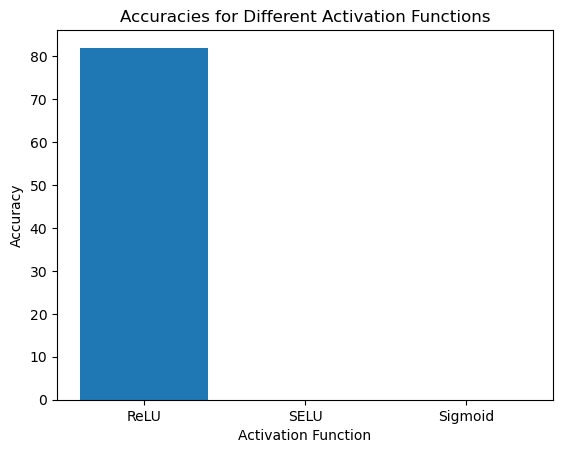

In [ ]:
import matplotlib.pyplot as plt

activation_functions = ['ReLU', 'SELU', 'Sigmoid']

plt.bar(activation_functions, accuracies)
plt.xlabel('Activation Function')
plt.ylabel('Accuracy')
plt.title('Accuracies for Different Activation Functions')
plt.show()
